<center><font size="+4">IProML 2021/2022</font></center>
<center><font size="+4">Introduction to Programming and</font></center>
<center><font size="+4">Machine Learning in Python</font></center>
<center><font size="+2">Scuola Normale Superiore, Pisa, Italy</font></center>

<center><font size="+2">Course responsibles</font></center>
<center><font size="+2">Andrea Vandin a.vandin@santannapisa.it</font></center>
<center><font size="+2">Daniele Licari d.licari@santannapisa.it</font></center>

---

<center><font size="+4">Lecture 5: </font></center>
<center><font size="+2"> Creation of word clouds for COVID-related online news</font></center>
</center>

---

# Computing and visulatizing the most important words in online news

This example shows that functions can hide a lot of complexity.
* E.g., we can download remote data by just invoking a function
* In particular, in this example we will:
    1.	Download all the articles the online service [NewsAPI](https://newsapi.org/)
    2.	Combine the articles into one document (`str`)
    3.	Clean data (removing punctuation and stopwords)
    4.	Compute word-frequency pairs
    5.	Visualize the analysis in a Word Cloud
    
 

*Some definitions:*

A **web service** is an application run by a web server that can be called from a series of URLs that will return their data in a format intended for parsing by a "generic" computer program rather than by a browser. As a result, web services can use something like XML (especially SOAP or so) or JSON is used.

An **Application Programming Interface (API)** allows two systems to communicate with one another. An API exactly defines the methods for one software program to interact with the other. 

![](images/web_server_web_service.png)

## The modules we need to use

In [9]:
# Python client library to integrate News API into your Python application
%pip install newsapi-python
# Python module for WordCloud
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for wordcloud, since package 'wheel' is not installed.
  Running setup.py install for wordcloud: started
  Running setup.py install for wordcloud: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import Python client to integrate News API into our Python application 
from newsapi import NewsApiClient 

# for creating wordclouds into your Python application 
from wordcloud import WordCloud, STOPWORDS 

# Import Matplotlib for visualization
import matplotlib.pyplot as plt

## Download Articles using NewsApi Client

__NewsApiClient__ is a local client for the online service [__NewsAPI__](https://newsapi.org/) that allows you to get news from [eveywhere in the world](https://newsapi.org/sources)
* Intuitively, an online service is like an online function running in a remote server (computer)
* A local client is a piece of code runnning in your machine that communicates with the online service
  * It allows you to easily interact with the online service
  * The interaction is typically done through a set of message exchanges as prescribed by the APIs of the service
* We need a `api_key` that is a univoque identifier 
  * necessary when making requests to be identified
  * can be obtained registering [here](https://newsapi.org/register)

There exist many online services accessible with Python (e.g. [Twitter API](https://www.tweepy.org/))
* Most of them follow this api-key approach
* E.g. to enforce subscriptions
<!-- * In our case, __we are using a free subscription that allows us to only get the first 250 characters from a news item__ -->

### Using the Python NewsAPI Client

We want to get **100 most relevant** articles about **coronavirus**, published in **usa-today** using [Everything NewsAPI service](https://newsapi.org/docs/endpoints/everything)
<!-- * This looks like a [normal function invocation](https://newsapi.org/docs/client-libraries/python) -->
<!-- * But under the hood a lot happens to contact the remote service 
(https://newsapi.org/v2/everything?q=coronavirus&sources=usa-today&language=en&pageSize=100&sortBy=relevancy&apiKey=345f8a0aa8c64d549fde1d8343d036f8) -->


Luckily, the function `<NewsApiClient>.get_everything` hides complexity to us
 - It uses the parameters chosen by the user to create the request to the online service.
 (es. https://newsapi.org/v2/everything?q=coronavirus&sources=usa-today&language=en&pageSize=100&sortBy=relevancy&apiKey=345f8a0aa8c64d549fde1d8343d036f8)
 - Transforms the service response into a data type that can be easily manipulated in python

In [19]:
# create and initialize the client with your API key:
newsapi = NewsApiClient(api_key='345f8a0aa8c64d549fde1d8343d036f8')

# use remote service and get results
json_data = newsapi.get_everything(q='coronavirus',         # All the articles that contain this word
                                    language='en',          # in English
                                    sources = 'usa-today',  # from usa-today (newspaper of interest)
                                    page_size=100,          # Get 100 articles
                                    sort_by='relevancy'     # order by relevancy (more closely related to q)
                                    )
# There exist many more parameters allowing us the ask for more articles, different sources (eg.'cnn, bbc-news,the-verge'), etc

The return value `json_data` is just a dictionary collecting information about the remote request

In [17]:
print(type(json_data))
print()
print(json_data.keys())
print()
print('The status of the request is',json_data['status'],'There are ',json_data['totalResults'],'articles matching the request.')
print('We got',len(json_data['articles']),'articles')
print()


<class 'dict'>

dict_keys(['status', 'totalResults', 'articles'])

The status of the request is ok There are  106 articles matching the request.
We got 100 articles



We can ignore all the metadata (i.e. the data about the remote request) and focus on the actual articles only

In [18]:
# get articles 
articles = json_data['articles'] 

# Get the description of the first article
content = articles[0]['description']
print('The content:')
print(content)
print('The content is long',len(content),"characters")

The content:
The Biden administration will end a Trump-era immigration policy, Title 42, that made it harder for migrants to seek asylum because of the pandemic.
The content is long 148 characters


Now, Let's implement the first function to avoid writing spaghetti code. We can use it to receive news from different topics (eg. 'Ukraine')

In [1]:
# def get_relevant_online_news(query: str,  source:str='usa-today', n_articles:int=100, language:str='en') -> list:
def get_relevant_online_news(query,  source='usa-today', n_articles=100, language='en'):
    """
    Download relevant 'n_articles' news that contain 'query' word from 'source' newspaper in 'language' language  using NewsAPI
    
    :param query: 
        str, keywords or phrases to search for in the news title and body.
    :param source: 
        str, the news source or blog you want news from  (default 'usa-today')
    :param n_articles: 
        int, the number of articles to return (default 100)
    :param language: 
        str, the language you want to get news
    :return: 
        list, list of articles
    ---
    Usage:
        # get top 50 relevant news from CNN about Ukraine
        articles = get_relevant_online_news('Ukraine', source='cnn',n_news=50)
    """

    # create and initialize the client with your API key:
    newsapi = NewsApiClient(api_key='345f8a0aa8c64d549fde1d8343d036f8')

    # use remote service and get results
    json_data = newsapi.get_everything(q=query,                 # All the articles that contain 'query' word
                                        language=language,      #  the language you want to get news
                                        sources = source,       # from news source
                                        page_size=n_articles,   # Get  number of articles
                                        sort_by='relevancy'     # order by relevancy (more closely related to q)
                                        )
    # get articles 
    articles = json_data['articles'] 
    
    return articles

# Python docstrings are strings used to document our code after the definition of a function, method, class, or module.

In [5]:
# print(get_relevant_online_news.__doc__)
help(get_relevant_online_news)

In [58]:
# articles = get_relevant_online_news('Ukraine')
articles = get_relevant_online_news('coronavirus')


## Combine the articles into one document 
Now let's combine the description of all the news into variable `contents`

In [20]:
def combine_articles(list_of_articles):
    """ 
    It concatenates the description of the news (passed as a parameter) in a string.
    
    :param list_of_articles:
        list of articles downloaded from NewAPI
    :return:
        a string that contains all the news descriptions
    """
    contents = ''
    for article in list_of_articles:
         #  check if key 'description' has Non-None value in dictionary 
        if article['description']:
            contents += article['description']+" "
            
    return contents



Overall we have 14202 characters


In [30]:
all_descriptions = combine_articles(articles)
print('Overall we have',len(all_descriptions),'characters')

Overall we have 14202 characters


## Data Cleaning

Let's clean the data removing not interesting words

### Implementing two functions for data cleaning

__Stop words__ are usually the most common words in any text ( like “the”, “of”, “to” and “and”), 
<!-- Prepositions, Determiners, Conjunctions -->
* They don’t tell us much about the actual content in a text
* These are the words we want to ignore - this is our data cleaning
 
We want to find the words that will help us differentiate a text from texts that are about different subjects. 
* __We will filter out the common words__.
* Of course, we are going to use a function for doing this

Furthermore, **we want to ignore punctuation**
* We are going to use it to delete all punctuation from a string

In [31]:
# to remove Punctuations from a string
def remove_punctuations(my_str): 
    """ 
    It removes punctuations from the string 'my_str'
    
    :param list_of_articles:
        string with punctuation to remove 
    :return:
        new string without punctuation
    """
    # sets of punctuation
    punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    
    str_no_punct = ""
    for char in my_str:
        if char not in punctuation:
            str_no_punct = str_no_punct + char
    return str_no_punct

# to remove STOPWORDS from a list of strings
def remove_stopwords(wordlist):
    """ 
    It removes STOPWORDS from the list of strings 'wordlist'
    
    :param list_of_articles:
        list of strings with STOPWORDS to remove 
    :return:
        new list of strings without STOPWORDS
    """
    return [w for w in wordlist if w not in STOPWORDS]

# for testing 
remove_stopwords(remove_punctuations('Andrea likes pizza and Python!! and you?').split())

['Andrea', 'likes', 'pizza', 'Python']

### Data cleaning function

In [37]:
# 1 cleaning data
def clean_data(content_to_clean):
    """
    It performs text cleaning by converting text to lower case 
    and removing punctuation and stopwords
    
    :param content_to_clean:
        str, string to clean
    :return:
        list, cleaned list of string (words) 
    """
    
    # simple text normalization: string in lower case
    content_to_clean = content_to_clean.lower()
    # remove punctuations
    no_punct_content = remove_punctuations(content_to_clean)
    # get list of words
    list_words = no_punct_content.split()
    # remove stopwords
    cleaned_content = remove_stopwords(list_words)
    

    return cleaned_content



In [39]:
clean_data('Andrea likes pizza and Python!! and you?')

['andrea', 'likes', 'pizza', 'python']

In [38]:
print('Before cleaning')
print(contents[:600])
print()

cleaned_content = clean_data(contents)

print('After cleaning')
print(cleaned_content[:200])
print()

Before cleaning
Impending Russian offensive in eastern Ukraine: Zelenskyy urges civilians to flee region Evacuations continue in Ukraine despite Friday's strike, Cawthorn will speak at Trump's rally and more news to start your weekend. Forcing Russian planes from Ukraine airspace could shift war across European borders – and escalate the conflict to nuclear warfare More than 1,700 students from Ukraine are studying in the U.S. many of whom are balancing school, activism and waiting for news from home. The world imports a third of its wheat from Ukraine and Russia. With exports disrupted, the US and other nati

After cleaning
['impending', 'russian', 'offensive', 'eastern', 'ukraine', 'zelenskyy', 'urges', 'civilians', 'flee', 'region', 'evacuations', 'continue', 'ukraine', 'despite', 'fridays', 'strike', 'cawthorn', 'will', 'speak', 'trumps', 'rally', 'news', 'start', 'weekend', 'forcing', 'russian', 'planes', 'ukraine', 'airspace', 'shift', 'war', 'across', 'european', 'borders', '–',

## Compute word-frequency pairs

Let's compute the frequency of use of words

In [40]:
# 2 computing word-frequency pairs
def analyze_data(list_cleaned_content):
    """
    It counts word frequency from 'list_cleaned_content' and makes a dictionary from it
      
    :param cleaned_content:
        list, list of string to analyze
    :return:
        dictionary of word-frequency pairs
    """
    
    wordcount = {}
    
    for w in list_cleaned_content:
        # check if the element exists in the dictionary
        if w in wordcount: 
            wordcount[w] += 1 # increase the value present at the element key by 1
        else:
            wordcount[w] = 1 # add that element as key and set its value as 1
            
    return wordcount



In [49]:
wordcount = analyze_data(cleaned_content)

## Visualize the analysis in a Word Cloud

In [53]:
# 3 visualizing the analysis in a Word Cloud
def visualize_data(wordcount, max_words= 150):
    """
    It plots word-frequency pairs as a Word Cloud 
    
    :param wordcount:
        list, dictionary of word-frequency pairs
    :param max_words:
        int, the maximum number of words
    """
    # generates WordCloud image from wordcount
    wc = WordCloud(width=1200,height=600, background_color='white', max_words = max_words).generate_from_frequencies(wordcount)
    # shows WordCloud using MatPlotLib
    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()



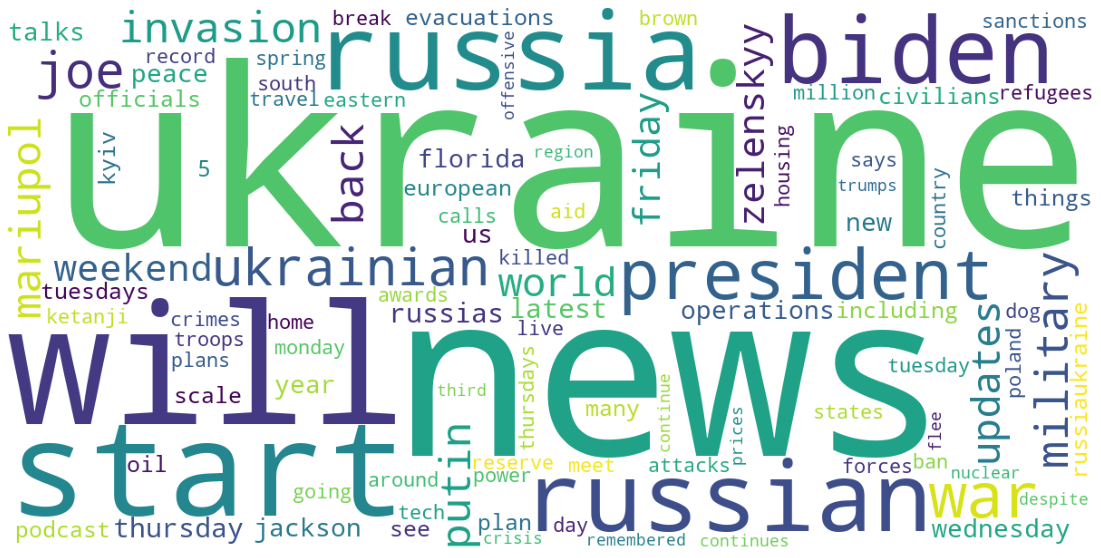

In [48]:
visualize_data(wordcount)

## Let's put everything in a function, so that we can run it easily for different sources

In [50]:
def make_world_cloud(query,source,n_articles=50):
    """
    Download relevant 'n_article' articles that contain 'query' from 'source' newspaper using NewsAPI
    and plot a wordcloud with the most common words in the corpus.
    
    :param query: 
        Keywords or phrases to search for in the article title and body.
    :param source: 
        the news source or blog you want headlines from
    :param n_articles:
        The number of articles to return (maximum 100)
    """
    # 1.  Download all the articles the online service NewsAPI
    articles = get_relevant_online_news(query=query, source=source, n_articles=n_articles)
    
    # 2. Combine the articles into one document (string)
    contents = combine_articles(articles)
    
    # 3. cleaning data
    cleaned_content = clean_data(contents)

    # 4. computing word-frequency pairs
    wordcount = analyze_data(cleaned_content)
 
    # 5. Visualizing the analysis in a Word Cloud
    visualize_data(wordcount)

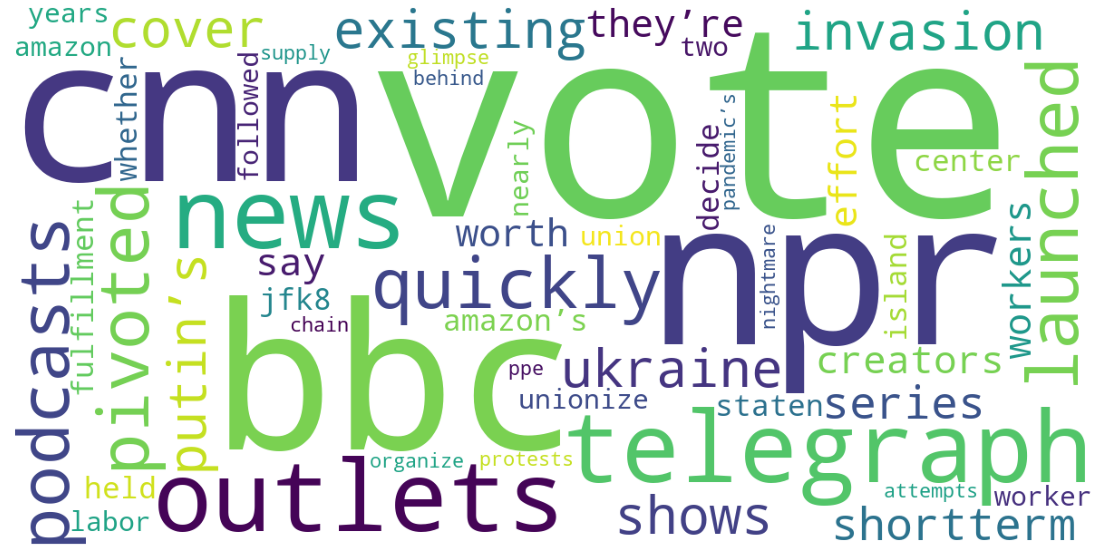

In [51]:
make_world_cloud('coronavirus','the-verge',100)

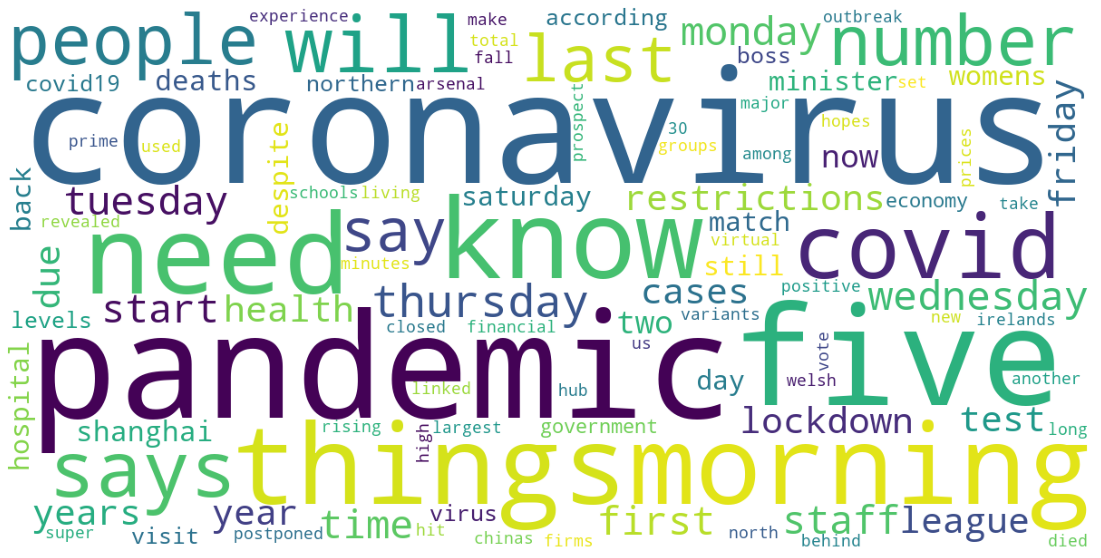

In [52]:
make_world_cloud('coronavirus','bbc-news',100)